In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
import json

import seaborn as sns
color_pal = sns.color_palette()

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5 
plt.rcParams['lines.markersize'] = 4
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14

In [223]:
df = pd.read_csv(r"..\new_datasets\datos_gramineas.csv")
df['fecha'] = pd.to_datetime(df['fecha'])

### Entreno y prueba con 2024

In [224]:
FEATURES = json.load(open('json/features_t+1.json', 'r', encoding='utf-8'))
TARGET = 'granos_de_polen_x_metro_cubico'

year = 2025

train_data = df[df['fecha'].dt.year < year].dropna(subset=[TARGET])
test_data = df[df['fecha'].dt.year == year].dropna(subset=[TARGET])

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
y_train_log = np.log1p(y_train)

X_test = test_data[FEATURES]
y_test = test_data[TARGET]
y_test_log = np.log1p(y_test)

In [225]:
# Añadir pesos

def calculate_weights(target_y, features_X, base_high_w=10.0, alert_w=20.0, spike_w=40.0):
    weights = np.ones(len(target_y))
    pollen = target_y.values
    
    # Tier 1: Low-Medium Levels (>= 10)
    weights[pollen >= 10] = base_high_w
    
    # Tier 2: Warnings/Alerts (>= 50)
    weights[pollen >= 50] = alert_w
    
    # Tier 3: "Explosive Spike" (Jump >= 300)
    if 'polen_lag_1' in features_X.columns:
        pollen_today = pollen
        pollen_yesterday = features_X['polen_lag_1'].values
        try:
            jump = pollen_today - pollen_yesterday
            explosive_mask = (jump >= 300)
            weights[explosive_mask] = spike_w
        except:
            pass
            
    return weights

pesos = calculate_weights(y_train, X_train)


In [226]:
# Aplicar ruido de seguridad

def apply_safety_noise(X, seed=None):
    X_noisy = X.copy()
    
    NOISE_LEVEL = 0.20
    SAFETY_BIAS = 0.90
    
    if 'granos_de_polen_x_metro_cubico' in X_noisy.columns:
        noise = np.random.normal(SAFETY_BIAS, NOISE_LEVEL, size=len(X_noisy))
        X_noisy['granos_de_polen_x_metro_cubico'] = X_noisy['granos_de_polen_x_metro_cubico'] * noise
    
    return X_noisy

X_train = apply_safety_noise(X_train, seed=42)

In [227]:
with open('json/optuna_best_params_t+1.json', 'r') as f:
    best_params = json.load(f)

prelim_reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    objective='reg:squarederror',
    **best_params
)

prelim_reg.fit(X_train, y_train_log)

importancias = pd.DataFrame({
    'feature': FEATURES, 
    'importance': prelim_reg.feature_importances_
}).sort_values('importance', ascending=False)

TOP_FEATURES = importancias[importancias['importance'] > 0.002]['feature'].tolist()

if len(TOP_FEATURES) < 10:
    TOP_FEATURES = importancias.head(10)['feature'].tolist()

X_train_clean = X_train[TOP_FEATURES]
X_test_clean = X_test[TOP_FEATURES]

In [228]:
with open('json/optuna_best_params_t+1.json', 'r') as f:
    best_params = json.load(f)

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    objective='reg:squarederror',
    **best_params
)

reg.fit(X_train_clean, y_train_log,
        eval_set=[(X_train_clean, y_train_log), (X_test_clean, y_test_log)],
        verbose=100, sample_weight=pesos)

[0]	validation_0-rmse:1.31406	validation_1-rmse:1.50329
[100]	validation_0-rmse:0.39783	validation_1-rmse:0.40853
[200]	validation_0-rmse:0.36058	validation_1-rmse:0.37955
[300]	validation_0-rmse:0.34301	validation_1-rmse:0.36729
[400]	validation_0-rmse:0.34222	validation_1-rmse:0.36645
[500]	validation_0-rmse:0.34172	validation_1-rmse:0.36547
[600]	validation_0-rmse:0.33961	validation_1-rmse:0.36280
[700]	validation_0-rmse:0.33886	validation_1-rmse:0.36238
[800]	validation_0-rmse:0.33947	validation_1-rmse:0.36309
[900]	validation_0-rmse:0.33850	validation_1-rmse:0.36236
[972]	validation_0-rmse:0.33861	validation_1-rmse:0.36263


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9945829727211198, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=4.574448120520625, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09942910000731134,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=973, n_jobs=None,
             num_parallel_tree=None, ...)

In [229]:
# Guardar el modelo
reg.get_booster().save_model('json/modelo_t+1.json')

In [230]:
preds_log = reg.predict(test_data[TOP_FEATURES])
preds_reales = np.expm1(preds_log)
test_data['prediccion'] = preds_reales

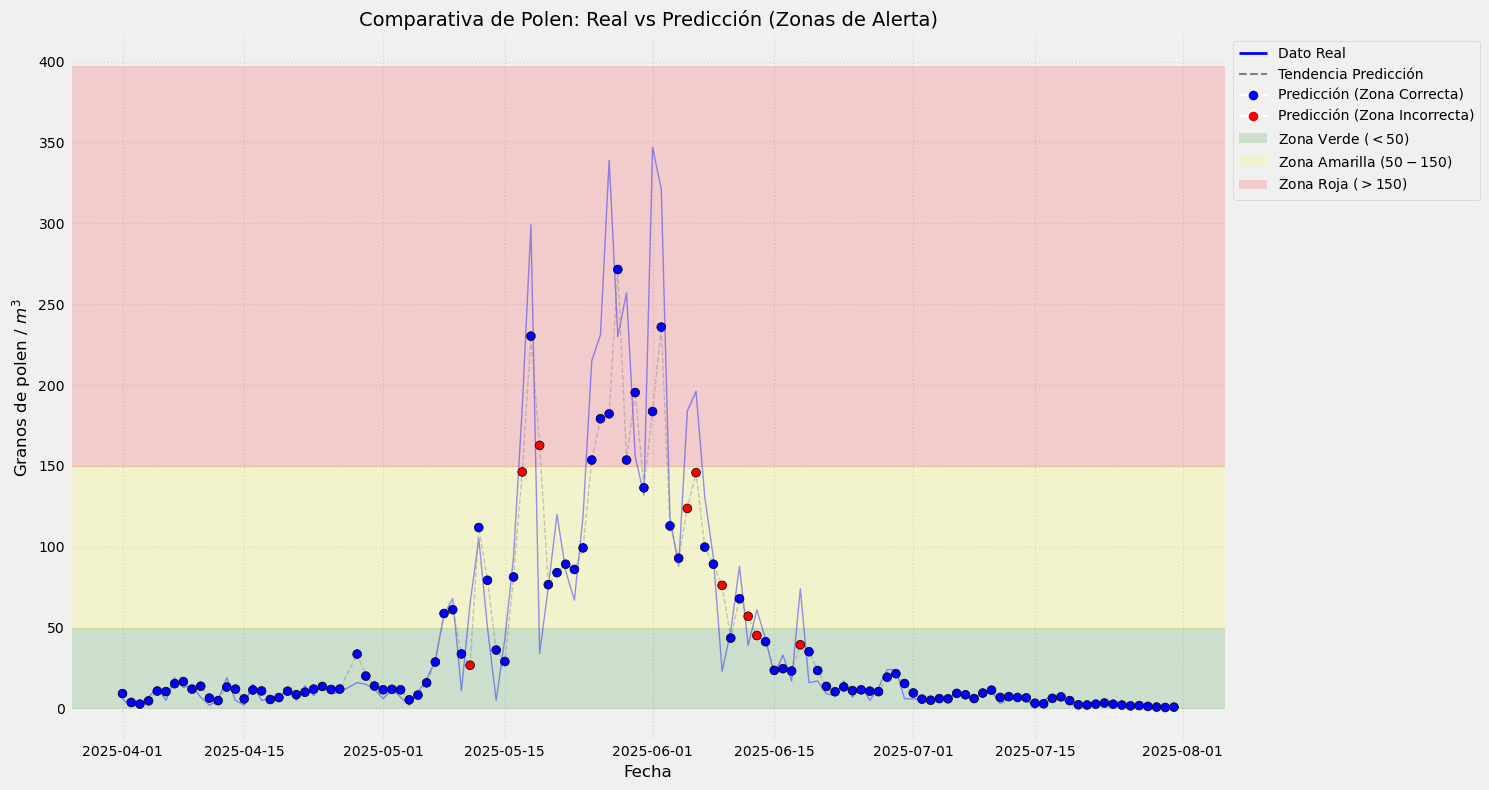

--- Métricas para el periodo Abril-Agosto 2024 ---
Error Medio Absoluto (MAE): 14.33 granos
Coeficiente de determinación ($R^2$): 0.83


In [231]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib.lines import Line2D

# 1. Filtrado de datos (Abril a Julio según tu lógica)
test_data_temporada = test_data[test_data['fecha'].dt.month.between(4, 7)].copy()

# 2. Definición de la lógica de zonas de polen
def obtener_zona(valor):
    if valor < 50:
        return 0  # Zona Verde
    elif 50 <= valor <= 150:
        return 1  # Zona Amarilla
    else:
        return 2  # Zona Roja

# 3. Calcular zonas y determinar color del punto (Rojo si falla la zona)
test_data_temporada['zona_real'] = test_data_temporada[TARGET].apply(obtener_zona)
test_data_temporada['zona_pred'] = test_data_temporada['prediccion'].apply(obtener_zona)
# El punto será rojo si la predicción está en una zona distinta al dato real
test_data_temporada['color_punto'] = np.where(
    test_data_temporada['zona_real'] != test_data_temporada['zona_pred'], 
    'red', 'blue'
)

plt.figure(figsize=(15, 8))

# 4. Dibujar áreas de fondo (Zonas de riesgo)
max_val = max(test_data_temporada[TARGET].max(), test_data_temporada['prediccion'].max()) + 50
plt.axhspan(0, 50, color='green', alpha=0.15, label='Bajo (< 50)')
plt.axhspan(50, 150, color='yellow', alpha=0.15, label='Moderado (50-150)')
plt.axhspan(150, max_val, color='red', alpha=0.15, label='Alto (> 150)')

# 5. Graficar líneas de tendencia
plt.plot(test_data_temporada['fecha'], test_data_temporada[TARGET], 
         label='Real (Gramíneas)', color='blue', alpha=0.4, linewidth=1)
plt.plot(test_data_temporada['fecha'], test_data_temporada['prediccion'], 
         label='Predicción Modelo', color='gray', linestyle='--', alpha=0.4, linewidth=1)

# 6. Graficar puntos diarios de la predicción con el color condicional
plt.scatter(test_data_temporada['fecha'], test_data_temporada['prediccion'], 
            c=test_data_temporada['color_punto'], s=40, zorder=5, 
            edgecolor='black', linewidth=0.5)

# Configuración de etiquetas y leyenda
plt.title('Comparativa de Polen: Real vs Predicción (Zonas de Alerta)')
plt.xlabel('Fecha')
plt.ylabel('Granos de polen / $m^3$')

# Leyenda personalizada para explicar los colores de los puntos
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Dato Real'),
    Line2D([0], [0], color='gray', linestyle='--', label='Tendencia Predicción'),
    Line2D([0], [0], marker='o', color='w', label='Predicción (Zona Correcta)', 
           markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Predicción (Zona Incorrecta)', 
           markerfacecolor='red', markersize=8),
    plt.Rectangle((0, 0), 1, 1, fc="green", alpha=0.15, label='Zona Verde ($<50$)'),
    plt.Rectangle((0, 0), 1, 1, fc="yellow", alpha=0.15, label='Zona Amarilla ($50-150$)'),
    plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.15, label='Zona Roja ($>150$)')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Métricas
mae = mean_absolute_error(test_data_temporada[TARGET], test_data_temporada['prediccion'])
r2 = r2_score(test_data_temporada[TARGET], test_data_temporada['prediccion'])

print(f"--- Métricas para el periodo Abril-Agosto 2024 ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f} granos")
print(f"Coeficiente de determinación ($R^2$): {r2:.2f}")

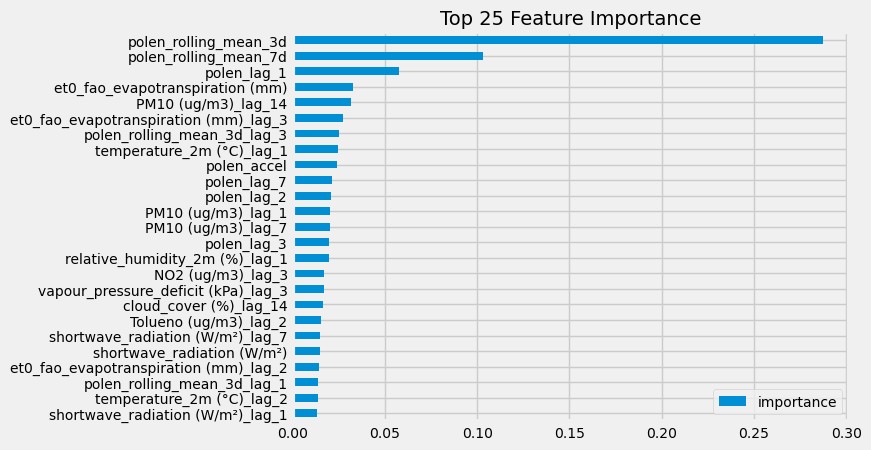

In [232]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance', ascending=False).head(25).sort_values('importance').plot(kind='barh', title='Top 25 Feature Importance')
plt.show()

### Predecir el próximo día

In [233]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [234]:
df = pd.read_csv(r"..\new_datasets\datos_gramineas.csv")
df = df.set_index("fecha")
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)

In [235]:
model = xgb.Booster()
model.load_model('json/modelo_t+1.json')

features_que_pide_el_modelo = model.feature_names

In [236]:
ultima_fila = df.tail(6)

input_data = ultima_fila[features_que_pide_el_modelo]

In [237]:
dmatrix_input = xgb.DMatrix(input_data)

prediccion_raw = model.predict(dmatrix_input)[0]

print(f"La predicción de polen para el próximo día es: {prediccion_raw:.2f}")

La predicción de polen para el próximo día es: 1.88
